In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cache
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import data_manager as dm

# BoW Image Retrieval with ORB Features
In order to judge our Neural Features methods we implement the 'old school' approach to our problem.      
We collect ORB features on each images, learn a dictionary upon it and acheive retrieval with Bag Of Words technique.    
Please find more information on ORB features [here](http://www.dabi.temple.edu/~hbling/Teaching/12S_8543/Presentation/Rublee11ORB.pdf), and more information on BoW techniques [here](https://arxiv.org/abs/1304.5168).    
The ORB method will give us 500 32-dimensional feature vectors per image.

## Getting our Data
Please refer to the repo's readme for a complete description of the data we are using.    
We collect our catalogue item and queries in dictionnaries where the key is the id present in the files names.
As we ignore some of them, id's are not continuous. What we call "class" is the corresponding number when only counting the images we kept.    
We refer to the dresses catalogue with **cat** and to the set of queries with **quer**.

In [8]:
# some data is ill-formated, we dont want it
to_ignore_file = "to_ignore.txt"
db_path = 'db/robes/'

cat_by_id = dm.get_images_by_id(db_path+'cat/',dm.id_getter_cat,dm.id_select_cat,to_ignore_file)
quer_by_id = dm.get_images_by_id(db_path+'mod/',dm.id_getter_quer,dm.id_select_quer,to_ignore_file)

class_of_id, id_of_class = dm.get_id_class_correspondance(cat_by_id)
print("\nThe database contains "+str(len(cat_by_id))+" query/item pairs such as:\n\t"+str(cat_by_id[0])+"\n\t"+str(quer_by_id[0]))

`db/robes/cat/` id ignored: [26, 2, 50, 53, 89, 110, 120, 127, 131, 144, 167, 159, 190, 142]
`db/robes/mod/` id ignored: [26, 2, 50, 53, 89, 110, 120, 127, 131, 144, 167, 159, 190, 142]

The database contains 196 query/item pairs such as:
	db/robes/cat/0_0.jpg
	db/robes/mod/0.jpg


## Orb Features Collection on the Catalogue
We compute the set of orb features for each image in the catalogue.    
We dump it to a file to avoid calculus when re-using the notebook.  

In [9]:
orb = cv2.ORB_create()

In [13]:
def compute_ORB_features(img_set):
    '''
        Routine to extract orb features for any image set, that is
        a dictionary id -> image_path.
        Returns a dictionary id -> list of features.
    '''
    to_return = {}
    for id_ in img_set:
        gray = dm.img_getter_gray(img_set[id_])
        kp, des = orb.detectAndCompute(gray,None)
        to_return[id_] = des
    return to_return

In [14]:
cat_ORB_per_id = cache.cache("dumps/cat_ORB_per_id.dump",compute_ORB_features,cat_by_id)

opening db/robes/cat/0_0.jpg
opening db/robes/cat/1_0.jpg
opening db/robes/cat/3_0.jpg
opening db/robes/cat/4_0.jpg
opening db/robes/cat/5_0.jpg
opening db/robes/cat/6_0.jpg
opening db/robes/cat/7_0.jpg
opening db/robes/cat/8_0.jpg
opening db/robes/cat/9_0.jpg
opening db/robes/cat/10_0.jpg
opening db/robes/cat/11_0.jpg
opening db/robes/cat/12_0.jpg
opening db/robes/cat/13_0.jpg
opening db/robes/cat/14_0.jpg
opening db/robes/cat/15_0.jpg
opening db/robes/cat/16_0.jpg
opening db/robes/cat/17_0.jpg
opening db/robes/cat/18_0.jpg
opening db/robes/cat/19_0.jpg
opening db/robes/cat/20_0.jpg
opening db/robes/cat/21_0.jpg
opening db/robes/cat/22_0.jpg
opening db/robes/cat/23_0.jpg
opening db/robes/cat/24_0.jpg
opening db/robes/cat/25_0.jpg
opening db/robes/cat/27_0.jpg
opening db/robes/cat/28_0.jpg
opening db/robes/cat/29_0.jpg
opening db/robes/cat/30_0.jpg
opening db/robes/cat/31_0.jpg
opening db/robes/cat/32_0.jpg
opening db/robes/cat/33_0.jpg
opening db/robes/cat/34_0.jpg
opening db/robes/ca

For instance, the ORB feature vector of catalogue image 0 are:

In [16]:
print(cat_ORB_per_id[0])
print(cat_ORB_per_id[0].shape)

[[220  11 200 ..., 245  15 128]
 [240  96 247 ..., 184  70  43]
 [173 201 100 ..., 130 226 224]
 ..., 
 [ 40 102 147 ..., 248  95 168]
 [ 54 104 145 ...,   3   6 166]
 [231  57  37 ..., 101 167 245]]
(500, 32)


### Numpy aggregation
We aggregate all the features of all the images in one big matrix;

In [18]:
all_ORB = cat_ORB_per_id[0]
for id_ in cat_ORB_per_id:
    if id_ == 0:
        continue
    all_ORB = np.r_[all_ORB, cat_ORB_per_id[id_]]
print(all_ORB.shape)

(97012, 32)


## Dictionary Learning
We then aggregate our 97012 feature vectors into 2048 clusters with k-means. 2048 was chosen to mimic the dimension of our Neural Features. Even with 12 processors this process is quite long (12m). We dump the resulting clusters even if they would be different at each run.   
### K-means aggregation

In [22]:
%%time
kmeans = KMeans(n_clusters=2048,n_jobs=12,verbose=10)
kmeans_result = cache.cache("dumps/cat_ORB_2048_kmeans.dump", kmeans.fit, all_ORB)

Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
start iteration
Initialization complete
done sorting
start iteration
done sorting
start iteration
done sorting
end inner loop
start iteration
done sorting
start iteration
done sorting
Iteration 0, inertia 7328017610.06
start iteration
done sorting
end inner loop
Initialization complete
end inner loop
end inner loop
start iteration
done sorting
Iteration 0, inertia 7321947559.23
start iteration
done sorting
end inner loop
Iteration 0, inertia 7321313438.77
start iteration
Iteration 0, inertia 7330868753.6
start iteration
done sorting
done sorting
Iteration 0, inertia 7330155158.64
start iteration
done sorting
end inner loop
end inner loop
Iteration 0, inertia 7330356171.41
start iteration
done sorting
Iteration 1, inertia 7004945629.58
start iteration
done sorting
start iteration
end inner loop
done sorting
end inner loop
end inner loop
end inner loop
Iteration 1, iner

done sorting
done sorting
end inner loop
end inner loop
end inner loop
Iteration 12, inertia 6739837720.46
start iteration
done sorting
Iteration 12, inertia 6744996782.14
Iteration 8, inertia 6760460689.91
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
end inner loop
Iteration 12, inertia 6745648858.36
start iteration
done sorting
end inner loop
end inner loop
Iteration 8, inertia 6758043419.55
start iteration
done sorting
end inner loop
end inner loop
Iteration 11, inertia 6744330914.07
start iteration
Iteration 12, inertia 6735444389.08
start iteration
Iteration 12, inertia 6743511277.39
start iteration
done sorting
done sorting
done sorting
end inner loop
Iteration 7, inertia 6766214349.7
start iteration
done sorting
end inner loop
Iteration 13, inertia 6737023047.04
start iteration
done sorting
Iteration 13, inertia 6741968388.26
start iteration
done sorting
Iteration 9, inertia 6752981088.06
start iteration
done sorting
end inner loop
end 

start iteration
done sorting
Iteration 18, inertia 6728941593.54
Iteration 22, inertia 6724533471.08
start iteration
start iteration
done sorting
done sorting
Iteration 22, inertia 6728095332.96
start iteration
done sorting
Iteration 22, inertia 6719233686.1
start iteration
Iteration 17, inertia 6728677548.77
start iteration
done sorting
done sorting
Iteration 23, inertia 6730547243.32
start iteration
done sorting
end inner loop
Iteration 21, inertia 6729097423.87
start iteration
done sorting
end inner loop
end inner loop
end inner loop
end inner loop
end inner loop
end inner loop
end inner loop
Iteration 19, inertia 6725111335.73
start iteration
done sorting
end inner loop
end inner loop
end inner loop
Iteration 18, inertia 6727500291.77
start iteration
Iteration 23, inertia 6727394821.22
start iteration
done sorting
Iteration 23, inertia 6724136724.84
start iteration
done sorting
done sorting
Iteration 22, inertia 6728474717.23
start iteration
done sorting
Iteration 19, inertia 67280

Iteration 27, inertia 6723013102.82
start iteration
end inner loop
done sorting
Iteration 33, inertia 6725056236.33
start iteration
Iteration 32, inertia 6725010066.15
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 33, inertia 6727352569.62
start iteration
Iteration 33, inertia 6721945593.23
start iteration
done sorting
done sorting
end inner loop
end inner loop
end inner loop
Iteration 30, inertia 6721694718.4
start iteration
done sorting
Iteration 34, inertia 6716495157.33
start iteration
done sorting
end inner loop
end inner loop
end inner loop
Iteration 29, inertia 6724695247.61
start iteration
done sorting
Iteration 33, inertia 6715991249.75
start iteration
end inner loop
done sorting
end inner loop
Iteration 18, inertia 6731182770.94
start iteration
done sorting
Iteration 34, inertia 6724993066.29
start iteration
done sorting
end inner loop
Iteration 34, inertia 6727248942.18
start iteration
Iteration 33, inertia 6724949625.01
start iteration
do

start iteration
done sorting
end inner loop
end inner loop
Iteration 40, inertia 6720888665.64
start iteration
done sorting
end inner loop
end inner loop
Iteration 38, inertia 6724213810.68
start iteration
done sorting
end inner loop
Iteration 43, inertia 6721631432.63
end inner loop
start iteration
Iteration 27, inertia 6726599738.85
start iteration
done sorting
done sorting
end inner loop
Iteration 44, inertia 6726691663.75
Iteration 44, inertia 6724607418.92
start iteration
center shift 0.000000e+00 within tolerance 5.476140e-01
done sorting
end inner loop
Iteration 43, inertia 6715577251.63
start iteration
Iteration 45, inertia 6715822885.02
start iteration
done sorting
done sorting
end inner loop
end inner loop
end inner loop
Iteration 38, inertia 6722038953.24
center shift 0.000000e+00 within tolerance 5.476140e-01
Iteration 41, inertia 6720870575.91
start iteration
done sorting
end inner loop
end inner loop
Iteration 44, inertia 6721615662.27
start iteration
end inner loop
Itera

### Dictionary Creation
For each of our image, we compute a visual histogram out of its ORB features. It consists in calculating an histogram of the clusters to which these features belong to.

In [24]:
def get_visual_hist(kmeans,orb_descs):
    '''
        Routine to extract a 'visual histogram', that is 
        a #cluster-dimensional histogram vector, out of a set 
        of orb descriptors.
    '''
    list_cluster = []
    list_cluster = kmeans.predict(orb_descs)
    hist = np.zeros(kmeans.n_clusters)
    for a in list_cluster:
        hist[a] += 1
    return hist.astype(int)

In [27]:
%%time
cat_ORB_dict = {}
for id_ in cat_by_id:
    cat_ORB_dict[id_] = get_visual_hist(kmeans,cat_ORB_per_id[id_])

CPU times: user 6.99 s, sys: 30.8 s, total: 37.8 s
Wall time: 2.38 s


For instance here's a visualization of the final feature vector of image 0:

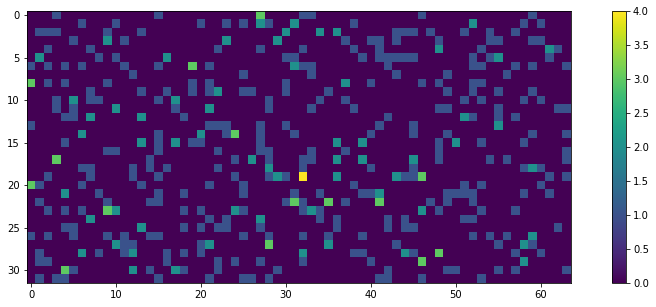

In [51]:
plt.figure(figsize=(15,5))
im = plt.imshow(cat_ORB_dict[0].reshape((2**5,2**6)))
plt.colorbar(im)
plt.show()